In [1]:
import numpy as np
import warnings
""" Suppress future warnings for seaborn."""
warnings.simplefilter(action='ignore', category=FutureWarning)

def create_dict():
       """ Define the different states as dictionaries. 
              - The states are defined by the name
              - The statenum
              - The reward for the different actions
              - The actions
              - The action values
              - The probability of the actions 
              - The expected value. """
       u_3 = {'name': 'u_3',       'state_num' : 3,                        'reward' : np.array([0, 4]),
              'action' : [0, 2],   'action_val' : np.array([0.5, 0.5]),    'prob': np.array([0.5, 0.5]),
              'expected_value': 0}
       u_2 = {'name': 'u_2',       'state_num' : 2,                        'reward' :np.array([8, -8]), 
              'action' : [0, 2],   'action_val' : np.array([0.5,  0.5]),   'prob': np.array([0.5, 0.5]),
              'expected_value': 0}
       u_1 = {'name': 'u_1',       'state_num' : 1,                        'reward' :np.array([1, -1 , 2]), 
              'action' : [0, 1, 2],'action_val' : np.array([1/3, 1/3, 1/3]),'prob': np.array([1/3, 1/3, 1/3]),
              'expected_value': 0}

       """ Define the connections between the states and action. In state u_1 we have 3 
       actions, only action 1 is connected to other states. The other states 
       are not connected at all."""
       Connection_dict = {'u_1':  {0 : [], 1 : [u_2 , u_3], 2:[]},
                     'u_2' : {0 : [], 1 : [], 2:[]},
                     'u_3' : {0 : [], 1 : [], 2: []}}
       
       return u_1, u_2, u_3, Connection_dict


In [2]:
import random as rand 

""" Choose an action weighted by the probabilites of the different actions and the
    next state. """
def choose_action_next_state(state, beta, Connection_dict):
    """ Get the different actions for the current state. """
    action = state['action']
    """ Get the action values for the current state. """
    action_val  = state['action_val']
    weights_prob = []
    
    """ Calulate the denominator of the softmax function. """
    denominator = np.sum(np.exp(beta * action_val))
    
    """ Calculate the probabilities of the different actions. """
    for action_loop in action_val:
        weights_prob += [np.exp(beta * action_loop) / denominator]

    """ Write the probabilities to the state dictionary. """
    state['prob'] = weights_prob
    
    """ Choose one action weighted by the probabilities. """
    chosen_action = rand.choices(action, weights_prob, k=1)[0]

    """ Get the next states for the chosen action. """
    next_states = Connection_dict[state['name']][chosen_action]

    """ Choose one of the next states. """
    if next_states != []:
        which_state = rand.choices(range(len(next_states)), k=1)[0]
        chose_next_state = next_states[which_state]
    elif next_states == []:
        
        chose_next_state = []
        
    return chosen_action, chose_next_state



In [3]:
""" Create a delta function for the current state, the next state and the chosen
    action. """
def delta_func(state, action, next_state):
    
    """ Get the index of the action in the action list."""
    index = state['action'].index(action)
    """ Get the reward for the chosen action."""
    reward = state['reward'][index]
    
    """ Calculate the expedted reward if we are at the leave of the decision tree. """
    if next_state == []:
        delta = reward + 0 - state['expected_value']
    
        """ Calculate the expected reward if we are not at the leave of the decision tree. """
    elif next_state != []:
            delta = reward + next_state['expected_value'] - state['expected_value']

    return delta


In [4]:
""" Update the action values for the different states, chosen actions and the delta. """
def update_action_values(state, chosen_action, delta, epsilon, epsilon_alpha):
    
    """ Loop through all actions """
    for action in state['action']:  
        
        """ Get index of the action in the action list."""
        index = state['action'].index(action)
    
        """ Update the action values for the chosen action. """
        if action == chosen_action:
            state['action_val'][index] = (1 - epsilon) * state['action_val'][index] + epsilon_alpha * delta
            """ Always attenuate the other action values. """
        elif action != chosen_action:
            state['action_val'][index] = (1 - epsilon) * state['action_val'][index]
            
    return state


In [5]:
""" Number of trials and blocks. """
number_trials = 1000
""" Nunmber of blocks. """
blocks = 1000

""" Define the parameters. """
epsilon = 0.2
epsilon_alpha = 0.075
beta = 0.5

""" Matrix to save the expected values for the different states and trials. """
res_exp_value = np.zeros((blocks, number_trials, 3,))
""" Matrix to save the probabilities of the different actions for the different states and trials. """
res_prob_actions = np.zeros((blocks, number_trials, 3,3))

""" Loop thorugh all blocks """
for m in range(blocks):
    
    """ Reset the states to the initial conditions. """
    u_1, u_2, u_3 , Connection_dict = create_dict()
 
    """ Loop through all trials."""
    for n in range(number_trials):
        """ Initial conditions to enter the while loop."""
        state = u_1
        next_state = ['next_state_active']
        
        for state_loop in [u_1, u_2, u_3]:
    
            if state == state_loop:
                """ Choose an action and also the next state. """
                action, next_state = choose_action_next_state(state, beta, Connection_dict)
                
                """ Calulate the delta for the current state, action and next state. """
                delta = delta_func(state, action, next_state)
                
                """ Update the action values for the current state, action and delta."""
                #state = update_action_values(state, action, delta, epsilon, epsilon_alpha)
            
                """ Update the expected value for the current state which is in the model 
                    w(u)."""
                state['expected_value'] +=  epsilon * delta 
                
                """ Save the expected value of the state and action in the result matrix. """
                res_exp_value[m, n, state['state_num']-1] = state['expected_value'] 
                            
                """ Save the probabilities of the different actions in the result matrix. """
                if state == u_1:
                    res_prob_actions[m, n, state['state_num']-1, :] = state['prob']
                else:
                    res_prob_actions[m, n, state['state_num']-1, 0] = state['prob'][0]
                    res_prob_actions[m, n, state['state_num']-1, 2] = state['prob'][1]
                    
                """ Update the state to the next state. """
                state = next_state
            
""" Filter out 0 values in res_exp_value_whole. """
res_exp_value[res_exp_value == 0] = np.nan
res_prob_actions[res_prob_actions == 0] = np.nan


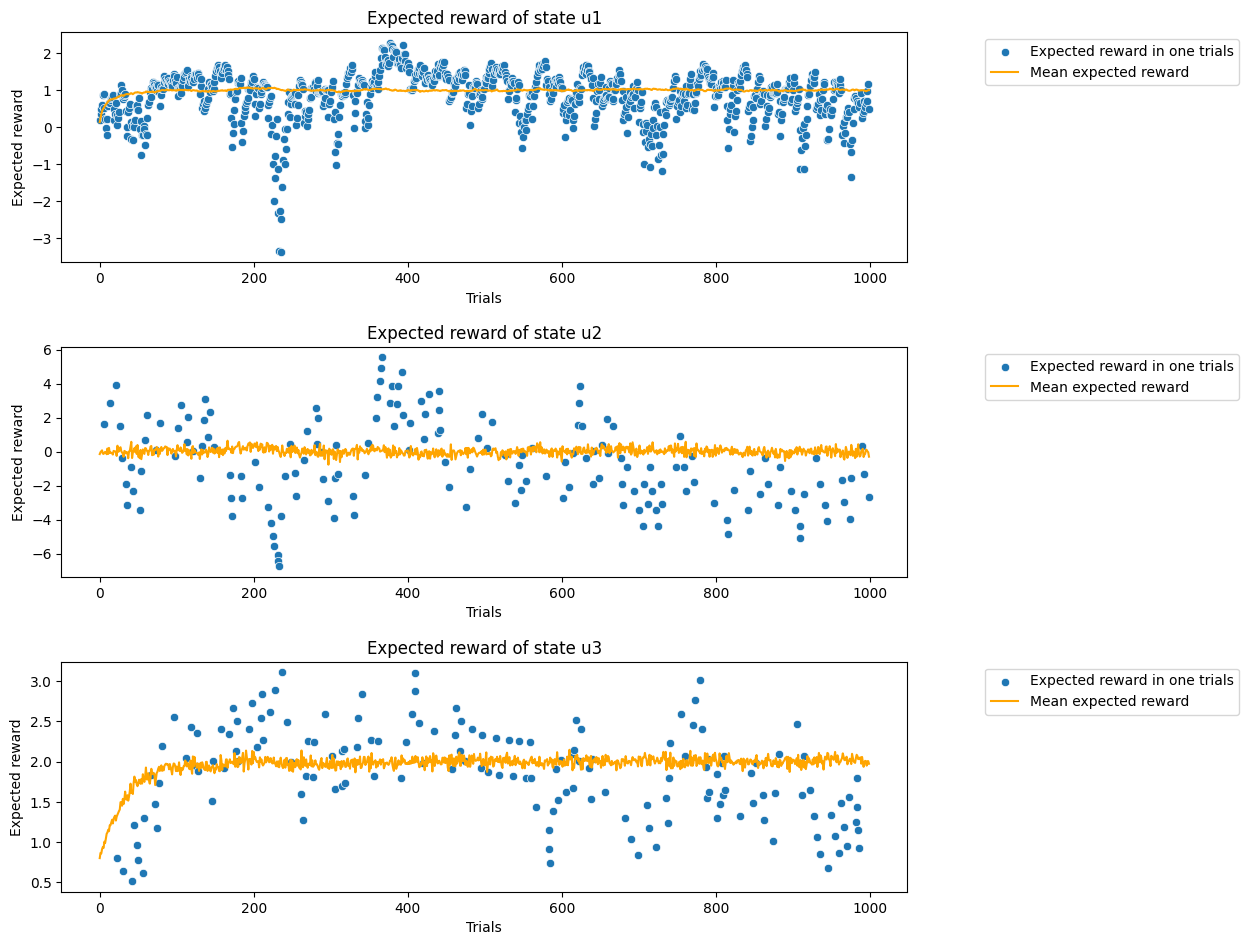

In [14]:
""" Plotting the results """
import seaborn as sns
import matplotlib.pyplot as plt

""" Make a figure with 3 subplots """
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig.tight_layout(pad=4.0)

g1 = sns.scatterplot(x = np.arange(number_trials), y = res_exp_value[1,:,0], ax = axs[0], label = 'Expected reward in one trials')
g1 = sns.lineplot(x = np.arange(number_trials), y = np.nanmean(res_exp_value[:,:,0], axis = 0), ax = axs[0], color = 'orange', label = 'Mean expected reward')
g1.set(title = 'Expected reward of state u1', xlabel='Trials', ylabel='Expected reward')
axs[0].legend(bbox_to_anchor=(1.4, 1.0))

g2 = sns.scatterplot(x = np.arange(number_trials), y = res_exp_value[1,:,1], ax = axs[1], label = 'Expected reward in one trials')
g2 = sns.lineplot(x = np.arange(number_trials), y = np.nanmean(res_exp_value[:,:,1], axis = 0), ax = axs[1], color = 'orange', label = 'Mean expected reward')
g2.set(title = 'Expected reward of state u2', xlabel='Trials', ylabel='Expected reward')
axs[1].legend(bbox_to_anchor=(1.4, 1.0))


g3 = sns.scatterplot(x = np.arange(number_trials), y = res_exp_value[1,:,2], ax = axs[2], label = 'Expected reward in one trials')
g3 = sns.lineplot(x = np.arange(number_trials), y = np.nanmean(res_exp_value[:,:,2], axis = 0), ax = axs[2], color = 'orange', label = 'Mean expected reward')
g3.set(title = 'Expected reward of state u3', xlabel='Trials', ylabel='Expected reward')
axs[2].legend(bbox_to_anchor=(1.4, 1.0))

""" Save the figure as jpg."""
plt.savefig('Policy_evaluation.jpg', bbox_inches='tight')